# Unconstrained optimizer prototype

In [24]:
"""
Global Parameters
"""
N = 10  # number of Fourier terms
kappa = 1  # permanent impact
lambda_ = 6  # temporary impact
xi_a = 0  # risk aversion of a -- not sure if it works with the approximate cost function
sigma = 0  # volatility of the stock -- not sure if it works with the approximate cost function
N_PLOT_POINTS = 100  # number of points for plotting

# Select the cost function
QUAD, APPROX = range(2)
COST_FUNCTION = APPROX

In [25]:
"""
Helper functions for Fourier series, ideally should be in a separate file
"""
import numpy as np
from scipy.integrate import quad
from typing import Callable, List, Tuple


def sin_coeff(func: Callable[[float], float], n: int,
              a: float = 0, b: float = 1) -> np.ndarray:
	""" Calculate coefficients of a sine series """
	coeffs = np.zeros(n)
	for i in range(1, n + 1):
		coeffs[i - 1] = quad(func, a, b, weight='sin', wvar=(i * np.pi))[0]
	return 2 * coeffs


def find_fourier_coefficients(functions: List[Callable[[float, float, float], float]],
                              kappa: float, lambda_: float, n: int, gamma: float = 1) -> List[np.ndarray]:
	all_coeffs = []
	for func in functions:
		coeffs = sin_coeff(lambda t: (func(t, kappa, lambda_) - t * gamma), n)
		all_coeffs.append(coeffs)
	return all_coeffs


def reconstruct_from_sin(t: float, coeffs: np.ndarray, n: [int | None] = None,
                         sin_values: [np.ndarray | None] = None) -> float:
	"""
    Reconstructs the function value at a given point `t` from a vector of sine coefficients.
	This is a slow version that uses loops.  It's replaced with a faster version

    :param t: The point at which to evaluate the reconstructed function.
    :param coeffs: An array of sine coefficients.
    :param n: The number of sine terms to use in the reconstruction. If None or greater than the length of `coeffs`,
              all coefficients are used.
    :param sin_values: Pre-computed values of sin(n * pi * t) as an array of the same size as coeffs for speedup
    :return: The reconstructed function value at the point `t`.

    Notes:
    ------
    The function reconstructs the value by summing the sine series up to the `n`-th term.
    If `n` is not specified or exceeds the length of `coeffs`, it defaults to using all available coefficients.
    """
	if n is None or n > len(coeffs):
		n = len(coeffs)
	i = np.arange(1, n + 1)
	if sin_values is None:
		sin_values = np.sin(i * np.pi * t)
	return coeffs[:n] @ sin_values


def reconstruct_deriv_from_sin(t: float, coeffs: np.ndarray, n: [int | None] = None, order: int = 1,
                               trig_values: [np.ndarray | None] = None) -> float:
	"""
    Reconstructs the nth derivative of the function value at a given point `t` from a vector of sine coefficients.
	This is a slow version that uses loops.  It's replaced with a faster version

    :param t: The point at which to evaluate the reconstructed function.
    :param coeffs: An array of sine coefficients.
    :param n: The number of sine terms to use in the reconstruction. If None or greater than the length of `coeffs`,
              all coefficients are used.
    :param order: The order of the derivative to reconstruct.
    :param trig_values: Pre-computed values of f(n * pi * t) as an array of the same size as coeffs for speedup
                        Where f = cos() for first deriv, -sin() for 2nd deriv etc.
                        It's the responsiblity of the user to ensure that the right values have been passed.
    :return: The reconstructed nth derivative of the function value at the point `t`.

    Notes:
    ------
    The function reconstructs the nth derivative by summing the sine series up to the `n`-th term and applying the
    appropriate derivative formula for sine functions.
    If `n` is not specified or exceeds the length of `coeffs`, it defaults to using all available coefficients.
    """
	if n is None or n > len(coeffs):
		n = len(coeffs)

	i = np.arange(1, n + 1)

	if trig_values is None:
		trig_values = np.sin(i * np.pi * t + order * np.pi / 2)
	return np.sum(coeffs[:n] * np.power(i * np.pi, order) * trig_values)

In [26]:
"""
Functions related to calculating the cost function via an analytical solution
"""
from functools import reduce
from itertools import product


# integral of cos(n pi t) sin(n pi t) in closed form
def int_cos_sin(n, m):
	pi = np.pi
	if n == m:
		ans = 0
	else:
		ans = (m - m * (-1) ** (m + n)) / (pi * (m ** 2 - n ** 2))

	return ans


def approx_cost_fn_no_integral_formula(a_n, b_n, kappa, lambd, verbose=False):
	"""
	This computes the cost function from the formula in the Real-world constraints paper.
	This approach avoids computing integrals.

	Parameters:
	a_n (array-like): Coefficients a_n for n from 1 to N
	b_n (array-like): Coefficients b_n for n from 1 to N
	kappa (float): Constant κ (kappa)
	lambd (float): Constant λ (lambda)

	Returns:
	float: The computed value of the expression I
	"""
	# Ensure input sequences are numpy arrays
	a_n = np.array(a_n, dtype=np.float64)
	b_n = np.array(b_n, dtype=np.float64)
	N = len(a_n)

	if len(b_n) != N:
		raise ValueError("Sequences a_n and b_n must be of the same length.")

	n = np.arange(1, N + 1)  # n from 1 to N

	# Compute the third term: kappa * [ (1 + lambd) / 2 + sum_{n odd} (2 * (b_n - a_n)) / (n * π) ]
	odd_indices = np.where(n % 2 == 1)[0]  # Indices where n is odd
	n_odd = n[odd_indices]
	a_n_odd = a_n[odd_indices]
	b_n_odd = b_n[odd_indices]
	pi = np.pi

	# I: \int_0^1 \dot{a} \dot{a} dt
	int_I = 1 + 0.5 * np.sum(n ** 2 * pi ** 2 * a_n ** 2)

	# II: \int_0^1 lambda \dot{b} \dot{a} dt
	int_II = lambd + (lambd / 2) * np.sum(n ** 2 * pi ** 2 * a_n * b_n)

	# III: \int_0^1 kappa \dot{a} a dt
	int_III = kappa / 2

	# Replaced the double loop with a faster version below
	# ans = 0
	# for n, a_co in enumerate(a_n, start=1):
	# 	for m, b_co in enumerate(b_n, start=1):
	# 		ans += a_co * b_co * n * pi * int_cos_sin(n, m)

	ans = reduce(
		lambda acc, x: acc + x[0] * x[1] * x[2] * pi * int_cos_sin(x[2], x[3]),
		((a_co, b_co, n, m) for n, a_co in enumerate(a_n, start=1) for m, b_co in enumerate(b_n, start=1)),
		0
	)

	iv4 = kappa * lambd * ans

	int_IV_1 = kappa * lambd * 0.5
	int_IV_2 = ((2 * lambd * kappa) / pi) * np.sum(b_n_odd / n_odd)
	int_IV_3 = -((2 * lambd * kappa) / pi) * np.sum(a_n_odd / n_odd)
	int_IV_4 = iv4

	int_IV = int_IV_1 + int_IV_2 + int_IV_3 + int_IV_4
	integral = int_I + int_II + int_III + int_IV

	if verbose:
		print("APPROX TOTAL COST FUNCTION FROM APPROX FORMULA:")
		print("int_I: ", int_I)
		print("int_II: ", int_II)
		print("int_III: ", int_III)
		print("int_IV: ", int_IV)
		print("\tint_0^1 lambda kappa t dt: ", int_IV_1)
		print("\tint_0^1 lambda kappa (b(t)-t) dt: ", int_IV_2)
		print("\tint_0^1 lambda kappa t * (a'(t)-1) dt: ", int_IV_3)
		print("\tint_0^1 lambda kappa (b(t) - 1)*(a'(t) - 1) dt: ", int_IV_4)
		print("\tTotal of components: ", int_IV_1 + int_IV_2 + int_IV_3 + int_IV_4)

		print("Loss function approximation formula: ", integral)

	return int_I + int_II + int_III + int_IV


Initial a_coeffs = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Initial guess cost = 8.4965

optimization time = 0.0965s
Optimized a_coeffs = [ 1.75  -0.531  0.214 -0.103  0.057 -0.034  0.022 -0.015  0.011 -0.008]
Optimized cost = -15.9559


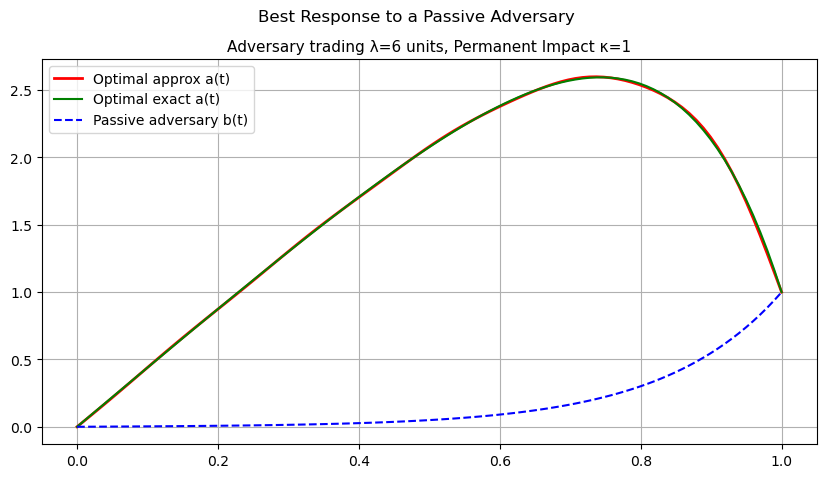

Approx - Exact Distance: L2 = 0.0696, max = 0.0268


In [27]:
"""
Miminize cost function given b
"""
import numpy as np
from numpy.linalg import norm
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import time

# Global variables
b_coeffs = None  # It will be estimated when needed


def b_func(t, kappa, lambda_, gamma=1):
	# return gamma * t ** 0.1
	return gamma * np.sinh(lambda_ * t) / np.sinh(lambda_)


def b_dot_func(t, kappa, lambda_, gamma=1):
	# return gamma * 0.1 * t ** (-0.9)
	return gamma * lambda_ * np.cosh(lambda_ * t) / np.sinh(lambda_)


def b_dbl_dot_func(t, kappa, lambda_, gamma=1):
	return gamma * lambda_ * lambda_ * np.sinh(lambda_ * t) / np.sinh(lambda_)


def b_vector(t):
	return (
		b_func(t, kappa, lambda_),
		b_dot_func(t, kappa, lambda_),
		b_dbl_dot_func(t, kappa, lambda_)
	)


def compute_exact_cost(a_func, a_dot_func, kappa, lambda_, verbose=False):
	def integrand_temp(t):
		_a_dot = a_dot_func(t, kappa, lambda_)
		_b_dot = b_dot_func(t, kappa, lambda_)
		return (_a_dot + lambda_ * _b_dot) * _a_dot

	def integrand_perm(t):
		_a = a_func(t, kappa, lambda_)
		_b = b_func(t, kappa, lambda_)
		_a_dot = a_dot_func(t, kappa, lambda_)
		return kappa * (_a + lambda_ * _b) * _a_dot

	temp_cost = quad(integrand_temp, 0, 1)[0]
	perm_cost = quad(integrand_perm, 0, 1)[0]

	if verbose:
		print("Exact temp_cost: ", temp_cost)
		print("Exact perm_cost: ", perm_cost)

	return temp_cost + perm_cost


def cost_function(a_coeffs):
	if COST_FUNCTION == QUAD:
		return cost_function_exact(a_coeffs)
	elif COST_FUNCTION == APPROX:
		return cost_function_approx(a_coeffs)
	else:
		raise NotImplementedError(f"Unknown cost function")


def cost_function_exact(a_coeffs):
	def a_func(t, kappa, lambda_, gamma=1):
		return reconstruct_from_sin(t, a_coeffs) + gamma * t

	def a_dot_func(t, kappa, lambda_, gamma=1):
		return reconstruct_deriv_from_sin(t, a_coeffs) + gamma

	return compute_exact_cost(a_func, a_dot_func, kappa, lambda_)


def cost_function_approx(a_coeffs, gamma=1):
	global b_coeffs
	if b_coeffs is None:
		b_coeffs = sin_coeff(lambda t: b_func(t, kappa, lambda_) - gamma * t, N)

	return approx_cost_fn_no_integral_formula(a_coeffs, b_coeffs, kappa, lambda_)


def plot_curves(init_guess, opt_coeffs, exact_solution, gamma=1) -> dict:
	""" Plot curves and and calc stats """
	t_values = np.linspace(0, 1, N_PLOT_POINTS)

	init_curve = [reconstruct_from_sin(t, init_guess) + gamma * t for t in t_values]
	opt_curve = [reconstruct_from_sin(t, opt_coeffs) + gamma * t for t in t_values]
	b_curve = [b_func(t, kappa, lambda_) for t in t_values]

	# Plot initial guess and optimized functions
	plt.figure(figsize=(10, 5))

	# plt.plot(t_values, init_curve, label='Initial guess', color='blue')
	plt.plot(t_values, opt_curve, label='Optimal approx a(t)', color='red', linewidth=2)
	plt.plot(t_values, exact_solution, label="Optimal exact a(t)", color="green")
	plt.plot(t_values, b_curve, label="Passive adversary b(t)", color="blue", linestyle="dashed")
	plt.suptitle(f'Best Response to a Passive Adversary')
	plt.title(f'Adversary trading λ={lambda_} units, Permanent Impact κ={kappa}', fontsize=11)
	plt.legend()
	plt.grid()
	plt.show()

	# Calculate stats
	diff_approx = opt_curve - exact_solution
	max_diff = np.max(np.abs(diff_approx))
	l2_diff = norm(diff_approx)

	return {'max': max_diff, 'L2': l2_diff}


# Define the system of differential equations with exogenous b(t)
def equations(t, y, xi_a):
	a, a_prime = y
	b, b_prime, b_dbl_prime = b_vector(t)
	a_double_prime = -(lambda_ / 2) * (b_dbl_prime + kappa * b_prime) + xi_a * sigma ** 2 * a
	return np.vstack((a_prime, a_double_prime))


# Boundary conditionss
def boundary_conditions(ya, yb):
	return np.array([ya[0], yb[0] - 1])


if __name__ == "__main__":
	# Initial guess for a_coeffs
	initial_guess = np.zeros(N)
	initial_cost = cost_function(initial_guess)
	print(f"Initial a_coeffs = {np.round(initial_guess, 3)}")
	print(f"Initial guess cost = {initial_cost:.4f}\n")

	# Minimize the cost function
	start = time.time()
	result = minimize(cost_function, initial_guess)
	print(f"optimization time = {(time.time() - start):.4f}s")

	# Optimized coefficients
	optimized_a_coeffs = result.x

	# Compute the cost with optimized coefficients
	optimized_cost = cost_function(optimized_a_coeffs)

	print(f"Optimized a_coeffs = {np.round(optimized_a_coeffs, 3)}")
	print(f"Optimized cost = {optimized_cost:.4f}")

	# Find the exact solution
	t = np.linspace(0, 1, N_PLOT_POINTS)
	y_init = np.zeros((2, t.size))
	sol = solve_bvp(lambda _t, y: equations(_t, y, xi_a), boundary_conditions, t, y_init)

	# Plot curves
	stats = plot_curves(initial_guess, optimized_a_coeffs, sol.y[0])
	print(f"Approx - Exact Distance: L2 = {stats['L2']:.4f}, max = {stats['max']:.4f}")